数据预处理之后生成的training.txt文件如下：

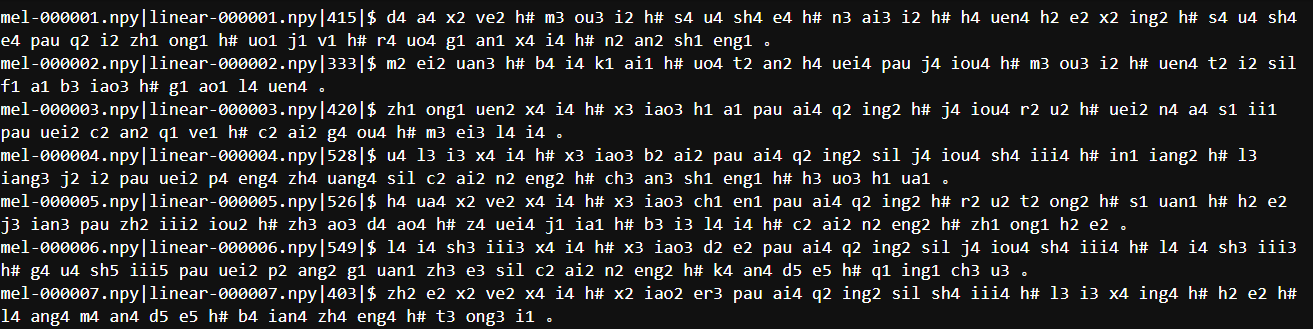

想要训练模型，首先要将数据喂给模型

In [ ]:
from datasets.datafeeder import DataFeeder

# Set up DataFeeder:
coord = tf.train.Coordinator()
with tf.variable_scope('datafeeder') as scope:
    feeder = DataFeeder(coord, input_path, hparams) #./training/train.txt

In [ ]:
class DataFeeder(threading.Thread):
    '''Feeds batches of data into a queue on a background thread.'''
    def __init__(self, coordinator, metadata_filename, hparams):
        super(DataFeeder, self).__init__()
        self._coord = coordinator
        self._hparams = hparams
        self._cleaner_names = [x.strip() for x in hparams.cleaners.split(',')]
        self._offset = 0
    
        # Load metadata:
        self._datadir = os.path.dirname(metadata_filename)
        with open(metadata_filename, encoding='utf-8') as f:
            self._metadata = [line.strip().split('|') for line in f]
            hours = sum((int(x[2]) for x in self._metadata)) * hparams.frame_shift_ms / (3600 * 1000)
            log('Loaded metadata for %d examples (%.2f hours)' % (len(self._metadata), hours))

        # Create placeholders for inputs and targets. Don't specify batch size because we want to
        # be able to feed different sized batches at eval time.
        self._placeholders = [
                        tf.placeholder(tf.int32, [None, None], 'inputs'),
                        tf.placeholder(tf.int32, [None], 'input_lengths'),
                        tf.placeholder(tf.float32, [None, None, hparams.num_mels], 'mel_targets'),
                        tf.placeholder(tf.float32, [None, None, hparams.num_freq], 'linear_targets')
        ]

        # Create queue for buffering data:
        queue = tf.FIFOQueue(8, [tf.int32, tf.int32, tf.float32, tf.float32], name='input_queue')
            self._enqueue_op = queue.enqueue(self._placeholders)
            self.inputs, self.input_lengths, self.mel_targets, self.linear_targets = queue.dequeue()
            self.inputs.set_shape(self._placeholders[0].shape)
            self.input_lengths.set_shape(self._placeholders[1].shape)
            self.mel_targets.set_shape(self._placeholders[2].shape)
            self.linear_targets.set_shape(self._placeholders[3].shape)

        # Load CMUDict: If enabled, this will randomly substitute some words in the training data with
        # their ARPABet equivalents, which will allow you to also pass ARPABet to the model for
        # synthesis (useful for proper nouns, etc.)
        if hparams.use_cmudict:
            cmudict_path = os.path.join(self._datadir, 'cmudict-0.7b')
            if not os.path.isfile(cmudict_path):
                raise Exception('If use_cmudict=True, you must download ' +
                  'http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b to %s'  % cmudict_path)
            self._cmudict = cmudict.CMUDict(cmudict_path, keep_ambiguous=False)
            log('Loaded CMUDict with %d unambiguous entries' % len(self._cmudict))
        else:
            self._cmudict = None

    def start_in_session(self, session):
        self._session = session
        self.start()

    def run(self):
        try:
            while not self._coord.should_stop():
                self._enqueue_next_group()
        except Exception as e:
            traceback.print_exc()
            self._coord.request_stop(e)
            
    def _enqueue_next_group(self):
        start = time.time()
        # Read a group of examples:
        n = self._hparams.batch_size
        r = self._hparams.outputs_per_step
        examples = [self._get_next_example() for i in range(n * _batches_per_group)]

        # Bucket examples based on similar output sequence length for efficiency:
        examples.sort(key=lambda x: x[-1])
        batches = [examples[i:i+n] for i in range(0, len(examples), n)]
        random.shuffle(batches)

        log('Generated %d batches of size %d in %.03f sec' % (len(batches), n, time.time() - start))
        for batch in batches:
            feed_dict = dict(zip(self._placeholders, _prepare_batch(batch, r)))
            self._session.run(self._enqueue_op, feed_dict=feed_dict)


    def _get_next_example(self):
        '''Loads a single example (input, mel_target, linear_target, cost) from disk'''
        if self._offset >= len(self._metadata):
            self._offset = 0
            random.shuffle(self._metadata)
        meta = self._metadata[self._offset]
        self._offset += 1

        text = meta[3]
        if self._cmudict and random.random() < _p_cmudict:
            text = ' '.join([self._maybe_get_arpabet(word) for word in text.split(' ')])

        input_data = np.asarray(text_to_sequence(text, self._cleaner_names), dtype=np.int32)
        linear_target = np.load(os.path.join(self._datadir, meta[0]))
        mel_target = np.load(os.path.join(self._datadir, meta[1]))
        return (input_data, mel_target, linear_target, len(linear_target))

    def _maybe_get_arpabet(self, word):
        arpabet = self._cmudict.lookup(word)
        return '{%s}' % arpabet[0] if arpabet is not None and random.random() < 0.5 else word

def _prepare_batch(batch, outputs_per_step):
    random.shuffle(batch)
    inputs = _prepare_inputs([x[0] for x in batch])
    input_lengths = np.asarray([len(x[0]) for x in batch], dtype=np.int32)
    mel_targets = _prepare_targets([x[1] for x in batch], outputs_per_step)
    linear_targets = _prepare_targets([x[2] for x in batch], outputs_per_step)
    return (inputs, input_lengths, mel_targets, linear_targets)

def _prepare_inputs(inputs):
    max_len = max((len(x) for x in inputs))
    return np.stack([_pad_input(x, max_len) for x in inputs])

def _prepare_targets(targets, alignment):
    max_len = max((len(t) for t in targets)) + 1
    return np.stack([_pad_target(t, _round_up(max_len, alignment)) for t in targets])

def _pad_input(x, length):
    return np.pad(x, (0, length - x.shape[0]), mode='constant', constant_values=_pad)

def _pad_target(t, length):
    return np.pad(t, [(0, length - t.shape[0]), (0,0)], mode='constant', constant_values=_pad)

def _round_up(x, multiple):
    remainder = x % multiple
    return x if remainder == 0 else x + multiple - remainder